<a href="https://colab.research.google.com/github/Squiro/droidAmp/blob/master/HPC/Ejercicios/Sinopoli_Alesio_ejercicio_2_GPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. Introducción**

El redimensionamiento de imágenes [1] [2] [3] (image scaling) es un problema con el cual nos topamos día a día: lo usamos cada vez que hacemos zoom en una imagen a través de un visor de imágenes, cada vez que decidimos redimensionar una imagen con un software de edición, o hasta incluso cada vez que jugamos un videojuego. 

El siguiente ejercicio es una adaptación en ejecución paralela del algoritmo de interporlación por aproximación. Pertenece a una familia de algoritmos que tienen como objetivo el redimesionamiento de imágenes. Dichos algoritmos hacen un balance entre la agilidad y la calidad resultante de la imagen redimensionada. Algoritmos más complejos de redimesionamiento de imágenes producen una imagen sin artefactos no deseados (como dientes de sierra, por ejemplo), pero en consecuencia su costo computacional es más alto, como también lo es su implementación.

El algoritmo de interporlación por aproximación es el más simple de los algoritmos de redimensionamiento. Supongamos que tenemos una imagen de entrada, la cual vamos a redimensionar en una imagen de salida. Por cada píxel de la imagen de salida, el algoritmo calcula cuál es el píxel más cercano a ese en la imagen de entrada. 

Cabe destacar que el píxel más cercano no tiene que ser el más cercano matemáticamente hablando. Es decir, no necesariamente tiene que ser el píxel que tenga una distancia menor. Existen diversas variaciones de este algoritmo, las cuales buscan obtener mejores resultados. [4] [5]

En nuestro caso, para simplificar los costos computacionales, utilizamos una variación del algoritmo que realiza un redondeo hacia el cero al momento de calcular las distancias.

Debido a la simpleza de este algoritmo, el mismo presenta un mal desempeño al aumentar la resolución de una imagen (upscaling), produciendo como resultados imágenes que son "muy cuadradas".

## **¿Por qué adaptarlo para la ejecución en paralelo?**

Las imágenes pueden ser representadas como matrices bidimensionales (o incluso tridimensionales, si trabajamos con imágenes RGB). Para aplicar este algoritmo, se debe recorrer completamente la matriz que representa a la imagen de salida, y calcular pixel por pixel secuencialmente. 

En términos de programación, esto implica la implementación de un for anidado, lo cual, en el peor de los casos, daría una complejidad computacional $O^2$. 

Aplicando paralelismo podemos evitar esta complejidad computacional y acelerar la ejecución del algoritmo. En este caso, tendremos muchos hilos en ejecución, cada uno accediendo a un píxel distinto y realizando los cálculos necesarios. Por lo que, de esta forma, evitamos la secuencialidad y podemos recorrer la matriz de salida en un tiempo menor.

## **Explicación detallada del algoritmo**

Supongamos que tenemos una imagen de 4 píxeles de ancho por 4 píxeles de alto (4x4), la cual la queremos redimensionar a una resolución de 8x8 píxeles. 

La primera imagen será la matriz de entrada. La segunda imagen corresponderá con la matriz de salida.

Para calcular los píxeles más cercanos, primero debemos calcular el ratio de redimensión para cada eje de la imagen (los ejes X e Y). Los mismos son calculados de la siguiente forma: 

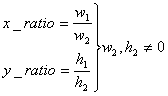

En nuestro caso, tanto el x_ratio como el y_ratio serán 4/8 = 0.5.

Una vez calculados los ratios, procedemos a recorrer la matriz de salida. Por cada pixel de la matriz de salida tenemos que calcular cuál es el píxel más cercano a la misma en la matriz de entrada. 

Para esto hacemos uso de los ratios previamente calculados: al multiplicar la posición (X,Y) del píxel de la matriz de entrada por los ratios correspondientes a cada eje, obtenemos las coordenadas del píxel más cercano en la matriz de entrada. Una vez obtenido, asignamos ese píxel a la posición (X,Y) de la matriz de salida.

La siguiente imagen ilustra el proceso:

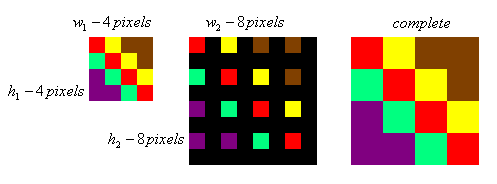

## **2. Armado del ambiente**

### **2.1 Instalación del módulo PyCuda en el notebook**

PyCuda es un wrapper que nos brinda la posibilidad utilizar la API de CUDA desde Python de una forma sencilla y rápida. Es necesario instalarlo a través de PIP para poder ejecutar este algoritmo.

In [1]:
!pip install pycuda

     |████████████████████████████████| 1.6MB 8.8MB/s 
     |████████████████████████████████| 71kB 10.7MB/s 
     |████████████████████████████████| 81kB 9.4MB/s 
  Created wheel for pycuda: filename=pycuda-2020.1-cp36-cp36m-linux_x86_64.whl size=620899 sha256=196372df3842b12c94b7e591e406e1be48d037f6749b240f52ca6908f6ef717a
  Stored in directory: /root/.cache/pip/wheels/8f/78/d1/5bb826f81d9d490297a348d818ff3ee6dd6f2075b06dde6ea0
  Created wheel for pytools: filename=pytools-2020.4.3-py2.py3-none-any.whl size=61374 sha256=a52179d0c976ea2ef3ea0d5beb4f9d716ad0ca27ed1798310faf6db4afe5b41c
  Stored in directory: /root/.cache/pip/wheels/af/c7/81/a22edb90b0b09a880468b2253bb1df8e9f503337ee15432c64
Successfully built pycuda pytools


### **2.2 Obtener la imagen a redimensionar y especificar alto y ancho de redimensión**

Ya que la base del algoritmo consiste en redimensionar una imagen, debemos alimentar al mismo con una. Para esto obtenemos una imagen a través de una URL utilizando la herramienta *wget* presente en GNU/Linux.

También, es necesario especificar el ancho y alto que tendrá la imagen de su redimensión. La unidad utilizada para estos parámetros es en píxeles.



In [2]:
#url_imagen = "https://github.com/wvaliente/SOA_HPC/blob/main/unlam.jpg?raw=true" #@param {type:"string"}
url_imagen = "https://www.muycomputer.com/wp-content/uploads/2017/08/Half-Life-2-Episode-3-1.jpg" #@param {type:"string"}
ancho_redim =  2500#@param {type:"integer"}
alto_redim = 2000 #@param {type:"integer"}

!wget {url_imagen} -O imagen.jpg

--2020-11-20 00:56:06--  https://www.muycomputer.com/wp-content/uploads/2017/08/Half-Life-2-Episode-3-1.jpg
Resolving www.muycomputer.com (www.muycomputer.com)... 151.139.245.223
Connecting to www.muycomputer.com (www.muycomputer.com)|151.139.245.223|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 49541 (48K) [image/jpeg]
Saving to: ‘imagen.jpg’

imagen.jpg          100%[===================>]  48.38K  --.-KB/s    in 0.02s   

2020-11-20 00:56:07 (2.59 MB/s) - ‘imagen.jpg’ saved [49541/49541]



## **3. Desarrollo**
Ejecución del algoritmo de redimensión de imágenes.

Thread: [ 16 , 16  ], Bloque : [ 157 , 125 ]
Total de Thread: [ 2512 , 2000  ]  =  5024000
Tiempo de ejecución: 1.615 ms


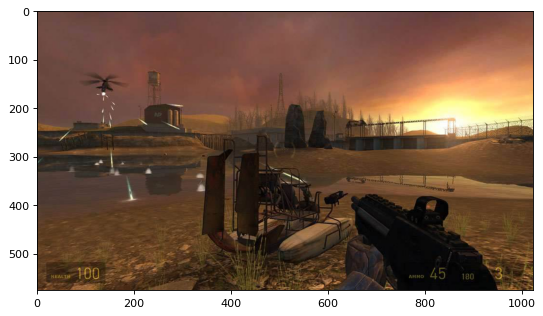

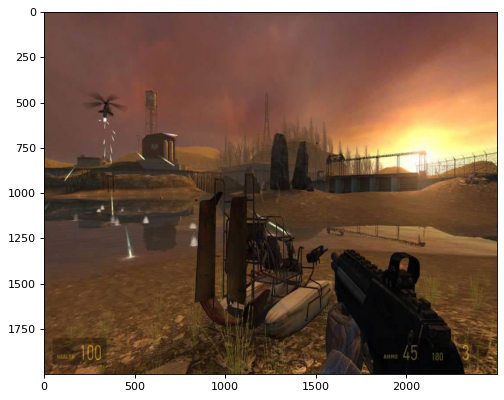

In [3]:
try:
  import matplotlib.pyplot as plt
  import numpy
  from PIL import Image 
  import pycuda.driver as cuda
  import pycuda.autoinit
  from pycuda.compiler import SourceModule
  from datetime import datetime
except ImportError as e:
  print("Hubo un error al importar los módulos. Asegurese de haber ejecutado las celdas correspondientes a Armado del Ambiente.")
  print("Módulos faltantes: ")
  print(e)
  raise

# Definición de función que transforma el tiempo en  milisegundos 
tiempo_en_ms = lambda dt:(dt.days * 24 * 60 * 60 + dt.seconds) * 1000 + dt.microseconds / 1000.0

img_nombre = 'imagen.jpg'

try: 
  image = Image.open( img_nombre ) 
except Exception as e:
  print("Hubo un error al abrir la imagen: ")
  print(e)
  print("El programa se cerrará")
  raise
  
# summarize some details about the image 
img_ancho, img_alto = image.size 

# Convierto la imagen comprimida en JPEG/PNG a array
img_original_cpu = numpy.asarray(a=image, order='C')
# El array de resultado tendrá una dimensión diferente, por eso lo inicializamos de esta forma
img_result_cpu = numpy.empty_like(prototype=img_original_cpu, shape=[alto_redim, ancho_redim, 3], order='C')

# Se reserva tanto el array que alojará la imagen original, como el array que alojará la imagen redimensionada
img_original_gpu = cuda.mem_alloc( img_original_cpu.nbytes )
img_result_gpu = cuda.mem_alloc( img_result_cpu.nbytes )

# GPU - Copio la memoria al GPU.
cuda.memcpy_htod( img_original_gpu, img_original_cpu )

# Calculamos el ratio de rescaling, este mismo será utilizado por los threads en la lógica del algoritmo
x_ratio = img_ancho/ancho_redim
y_ratio = img_alto/alto_redim

# CPU - Defino la función kernel que ejecutará en GPU.
# Cuidado con el tipo de puntero de las imágenes. Aparentemente son char pointers.
module = SourceModule("""
__global__ void kernel_rescaling(float x_ratio, float y_ratio, int ancho, int ancho_redim, int alto_redim, char *img_original, char *img_resultado)
{
  // Calculo las coordenadas del Thread en dos dimensiones.
  int idx = threadIdx.x + blockIdx.x*blockDim.x;
  int idy = threadIdx.y + blockIdx.y*blockDim.y;

  if( idx < ancho_redim && idy < alto_redim )
  {
      int new_x = (idx*x_ratio);
      int new_y = (idy*y_ratio);

      img_resultado[(idx+(idy*ancho_redim))*3] = img_original[(new_x+(new_y*ancho))*3];
      img_resultado[(idx+(idy*ancho_redim))*3+1] = img_original[(new_x+(new_y*ancho))*3+1];
      img_resultado[(idx+(idy*ancho_redim))*3+2] = img_original[(new_x+(new_y*ancho))*3+2];      
  }
}
""") 

# CPU - Genero la función kernel.
kernel = module.get_function("kernel_rescaling")

dim_hilo_x = 16
dim_bloque_x = numpy.int( (ancho_redim+dim_hilo_x-1) / dim_hilo_x )

dim_hilo_y = 16
dim_bloque_y = numpy.int( (alto_redim+dim_hilo_y-1) / dim_hilo_y )

print( "Thread: [", dim_hilo_x, ",", dim_hilo_y, " ], Bloque : [", dim_bloque_x, ",", dim_bloque_y, "]" )
print( "Total de Thread: [", dim_hilo_x*dim_bloque_x, ",", dim_hilo_y*dim_bloque_y, " ]", " = ", dim_hilo_x*dim_bloque_x*dim_hilo_y*dim_bloque_y )

tiempo_gpu = datetime.now()

kernel(numpy.float32(x_ratio), numpy.float32(y_ratio), numpy.int32(img_ancho), numpy.int32(ancho_redim), 
       numpy.int32(alto_redim), img_original_gpu, img_result_gpu, block=( dim_hilo_x, dim_hilo_y, 1 ), grid=(dim_bloque_x, dim_bloque_y,1) )

tiempo_gpu = datetime.now() - tiempo_gpu

print("Tiempo de ejecución: " + str(tiempo_en_ms(tiempo_gpu)) + " ms")

# GPU - Copio el resultado desde la memoria GPU.
cuda.memcpy_dtoh( img_result_cpu, img_result_gpu )

# Muestro la imagen Original el filtro.

#plt.figure()
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
imgplot=plt.imshow( img_original_cpu )

# Muestro la imagen luego de aplicarle el filtro.
#plt.figure()
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
imgplot=plt.imshow( img_result_cpu )


## **4. Tabla de pasos**

| Procesador | Función                | Detalle                                                                                                   |
|------------|------------------------|-----------------------------------------------------------------------------------------------------------|
| CPU        | @param     | Lectura de los parámetros de redimensionamiento desde Colab. |
| CPU        | pip install pycuda     | Instalación del módulo de PyCuda en el documento. Necesario para ejecutar código CUDA a través de Python. |
| CPU        | wget url_imagen        | Descarga de la imagen que será redimensionada.                                                            |
| CPU        | import                 | Importa los módulos necesarios para el funcionamiento del script.                                         |
| CPU        | Imagen.open()          | Abre el archivo de la imagen y lo almacena en la memoria del script.                                      |
| CPU        | numpy.asarray(imagen)  | Convierte la imagen a un array multi-dimensional de enteros.                                              |
| CPU        | numpy.empty_like()     | Genera un array donde se almacenará la imagen redimensionada. El array posee la dimensión de salida.      |
| GPU        | cuda.mem_alloc()       | Reserva memoria para las imágenes en GPU.                                                                 |
| GPU        | cuda.memcpy_htod()     | Copia los arrays de las imágenes desde la memoria del procesador a la memoria de la GPU.                  |
| CPU        | x_ratio, y_ratio       | Calcula los ratios de redimensión de cada eje.                                                            |
| CPU        | SourceModule           | String literal de Python que posee el código CUDA que será ejecutado en la GPU.                           |
| CPU        | module.get_function()   | Convierte el SourceModule del kernel en una función de Python.                                            |
| CPU        | dim_hilo_x, dim_hilo_y | Calcula las dimensiones de los hilos para ejecución 2D.                                                   |
| CPU        | datetime.now() | Toma el tiempo actual.                                                        |
| GPU        | kernel()               | Ejecución del código CUDA en la GPU, enviando los parámetros necesarios.                                  |
| CPU        | memcpy_dtoh            | Copia el área de memoria de la GPU donde se encuentra la imagen redimensionada a la memoria RAM.          |
| CPU        | plt.imshow             | Muestra la imagen original.                                                                               |
| CPU        | plt.imshow             | Muestra la imagen redimensionada.                                                                         |

## **5. Conclusiones**

### **Breve repaso**

El redimensionamiento de imágenes es un problema muy común que se repite constantemente en la actualidad. Cada vez que hacemos zoom en una imagen (sea cual sea el software) estamos aplicando un redimensionamiento. 

Existen varios algoritmos de redimensionamiento. El objetivo de estos es realizar el redimensionamiento en el menor tiempo posible, con la mejor calidad posible. Los algoritmos más complejos realizan más cálculos y consumen más tiempo de ejecución, pero otorgan una calidad mejor como resultado. Los algoritmos más simples pueden producir artefactos no deseados en la imagen.

En este ejercicio se utilizó el algoritmo de interpolación por aproximación, conocido en inglés como Nearest Neighbour. Este algoritmo es uno de los más simples: puede ser ejecutado sin problema en una CPU en un tiempo aceptable. Sin embargo, al ser tan simple, las imágenes que produce pueden tener artefactos no deseados como "dientes de sierra".

### **Resultados**

Los resultados fueron obtenidos en base a la imagen por defecto mencionada en el punto 2.2 de este notebook, con un redimensionamiento de 250 x 200. 

Podemos observar los resultados a simple vista: la imagen, cuyo tamaño original es de 1024x768, se redimensionó correctamente. Sin embargo, si el lector tiene buena vista, podrá notar que la imagen redimensionada tiene un aspecto "pixelado" en ciertas partes, y una pérdida de calidad en otras. Estos artefactos son los producidos por el algoritmo de interpolación lineal. 

### **Comparaciones**


Se realizaron dos pruebas compartivas para este ejercicio.

La primera prueba utiliza la imagen que se puede apreciar en este enlace: https://github.com/wvaliente/SOA_HPC/blob/main/unlam.jpg?raw=true, con un redimensionamiento hacia la resolución 250x200.

La segunda prueba se realizó utilizando la siguiente imagen: https://www.muycomputer.com/wp-content/uploads/2017/08/Half-Life-2-Episode-3-1.jpg, con un redimensionamiento hacia la resolución 2500x2000.


**Resultados Prueba 1**


| Tipo procesador | Tiempo de ejecución |
|-----------------|----------------------------------|
| GPU             | 0.249 ms                         |
| CPU             | 77.267 ms                        |


**Resultados Prueba 2**

| Tipo procesador | Tiempo de ejecución (ms) |
|-----------------|----------------------------------|
| GPU             | 1.615 ms                        |
| CPU             | 7440.137 ms                     |


Nuevamente (y ya no debería ser sorpresa luego del primer ejercicio) la GPU excede y logra realizar la tarea en un tiempo menor que el CPU. 

En la primera prueba, en el tiempo en que el CPU realizó una redimensión, la GPU podría haber redimensionado 309 veces la misma imagen. 

En la segunda prueba esto se refleja aún más: la CPU tardó 7 segundos en realizar el redimensionamiento, mientras que la GPU lo realizó en menos de 2 milisegundos.

### **Sugerencias**

Posibles mejoras de este ejercicio podrían ser desarrollar otros algoritmos pertenecientes a la familia de algoritmos de redimensionamiento, en especial aquellos que presenten una complejidad mayor.

También se podría mejorar el ejercicio para que realice varias transformaciones de una imagen al mismo tiempo, no solo un redimensionamiento. Por ejemplo, realizar rotaciones, "shiftings", cambios de brillo, etc. Esto convertiría al ejercicio en una herramienta potente de pre-procesamiento de imágenes, la cual podría ser utilizada para redes neuronales convolucionales.

### **Lecciones aprendidas**

Como demostramos en el desarrollo de este ejercicio, es posible implementar los algoritmos de redimensionamiento de imágenes para que pueden ser ejecutados con el uso de paralelismo, obteniendo como resultado un tiempo de ejecución menor, y evitando la complejidad computacional cuadrática de estos algoritmos.

Si bien los videojuegos son los precursores de la utilización de este tipo de técnicas en la GPU (comúnmente llamado anti-aliasing en los mismos), como mencionamos en la introducción de este ejercicio, el redimensionamiento de imágenes es algo que usamos todos los días, en un sin fin de aplicaciones y programas de software, incluso sin darnos cuenta. Estas aplicaciones se verían altamente beneficiadas por el uso de paralelismo para la ejecución de los algoritmos de redimensionamiento.

Es notable destacar que algunas aplicaciones profesionales de edición de vídeo o imágenes hacen uso del parelelismo. Por ejemplo, los programas de edición de Adobe poseen una opción llamada "GPU acceleration rendering". [6]

Podemos concluir que, a medida que las tecnologías relacionadas con las GPU avancen, cada vez será más fácil y menos costoso disponer de tarjetas gráficas capaces de realizar paralelismo. Hoy en día la mayoría de las placas madres tienen una tarjeta gráfica integrada. Es muy posible que en el futuro incluso ese tipo de tarjetas gráficas puedan realizar ejecuciones en paralelo, pudiendo de esta forma acceder a los beneficiones del paralelismo en cualquier tipo de computadora, incluso en aquellas de pocas prestaciones.



## **6. Bibliografía**

[1]  J. A. Parker, R. V. Kenyon y D. E. Troxel, "Comparison of Interpolating Methods for Image Resampling," en IEEE Transactions on Medical Imaging, vol. 2, no. 1, pp. 31-39, March 1983, doi: 10.1109/TMI.1983.4307610.

[2] Dianyuan Han, "Comparison of Commonly Used Image Interpolation Methods", en Proceedings of the 2nd International Conference on Computer Science and Electronics Engineering, 2013. Disponible en: https://www.atlantis-press.com/article/4822.pdf

[3] Vaishali Patel1 y Kinjal Mistree, "A Review on Different Image Interpolation Techniques for Image Enhancement", en International Journal of Emerging Technology and Advanced Engineering, Volume 3, Issue 12, 2013. Disponible en: http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.443.5747&rep=rep1&type=pdf 

[4] Olivier Rukundo y B. T. Maharaj, "Optimization of Image Interpolation based on Nearest Neighbour Algorithm,” VISAPP, 2014. Disponible en: https://www.scitepress.org/Papers/2014/47425/47425.pdf

[5] Olivier Rukundo y Hanqiang Cao, "Nearest Neighbor Value Interpolation", en IJACSA, Vol 3. No.4, 2012. Disponible en: https://thesai.org/Downloads/Volume3No4/Paper_5-Nearest_Neighbor_Value_Interpolation.pdf  

[6] Adobe. (2020) GPU Accelerated Rendering & Hardware Encoding. [En línea]. Disponible en: https://helpx.adobe.com/x-productkb/multi/gpu-acceleration-and-hardware-encoding.html
